In [44]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.ticker import AutoLocator, AutoMinorLocator, LogLocator
import glob
import os
import sys
from pathlib import Path

# Where am I running?
try:
    # Normal script
    here = Path(__file__).resolve().parent
except NameError:
    # Notebook / REPL
    here = Path.cwd()

phys_const_path = (here / '..' / 'phys_const').resolve()
sys.path.append(str(phys_const_path))

nsm_plots_path = (here / '..' / 'nsm_plots').resolve()
sys.path.append(str(nsm_plots_path))

import phys_const as pc
import plot_functions as pf

In [45]:
# direct = '/pscratch/sd/u/uo1999/gw170817_sim/att_convergence_010m/att_1.0e-05_0.65_ye'
# finaldir = 'att_1.0e-05_0.65_ye'
# file = '/allData.h5'
# parfile = '/plt09600_particles'

# direct = '/pscratch/sd/u/uo1999/gw170817_sim/att_convergence_010m/att_1.0e-05'
# finaldir = 'att_1.0e-05'
# file = '/allData.h5'
# parfile = '/plt09600_particles'

# direct = '/pscratch/sd/u/uo1999/gw170817_sim/high_angular_res_sim'
# finaldir = 'high_angular_res_sim'
# file = '/allData.h5'
# parfile = '/plt00960_particles'

direct = '/pscratch/sd/u/uo1999/gw170817_1.00Ye/att_convergence_010m/att_1.0e-05'
finaldir = '92_ppEb'
file = '/allData.h5'
parfile = '/plt09600_particles'
num_particles_per_energy_bin = 92
num_energy_bins = 13
time_s = 0.32/1000 # seconds

# direct = '/pscratch/sd/u/uo1999/gw170817_1.00Ye/classical_transport/92_ppEb'
# finaldir = '92_ppEb'
# file = '/allData.h5'
# parfile = '/plt00384_particles'
# num_particles_per_energy_bin = 92
# num_energy_bins = 13
# time_s = 0.32/1000 # seconds

# direct = '/pscratch/sd/u/uo1999/gw170817_1.00Ye/classical_transport/378_ppEb'
# finaldir = '378_ppEb'
# file = '/allData.h5'
# parfile = '/plt00960_particles'
# num_particles_per_energy_bin = 378
# num_energy_bins = 13
# time_s = 0.32/1000 # seconds

# direct = '/pscratch/sd/u/uo1999/gw170817_1.00Ye/classical_transport/1506_ppEb'
# finaldir = '1506_ppEb'
# file = '/allData.h5'
# parfile = '/plt00384_particles'
# num_particles_per_energy_bin = 1506
# num_energy_bins = 13
# time_s = 0.32/1000 # seconds

In [46]:
rho_ye_T_h5py = h5py.File(direct+'/rho_Ye_T.hdf5', 'r')

# number of cells
Nx = np.array(rho_ye_T_h5py['/ncellsx'])
Ny = np.array(rho_ye_T_h5py['/ncellsy'])
Nz = np.array(rho_ye_T_h5py['/ncellsz'])
print(f'Nx = {Nx}, Ny = {Ny}, Nz = {Nz}')

# cell size
dx = ( np.array(rho_ye_T_h5py['/xmax_cm']) - np.array(rho_ye_T_h5py['/xmin_cm']) ) / np.array(rho_ye_T_h5py['/ncellsx']) # cm
dy = ( np.array(rho_ye_T_h5py['/ymax_cm']) - np.array(rho_ye_T_h5py['/ymin_cm']) ) / np.array(rho_ye_T_h5py['/ncellsy']) # cm
dz = ( np.array(rho_ye_T_h5py['/zmax_cm']) - np.array(rho_ye_T_h5py['/zmin_cm']) ) / np.array(rho_ye_T_h5py['/ncellsz']) # cm
cellvolume = dx * dy * dz # cm^3
print(f'dx = {dx} cm, dy = {dy} cm, dz = {dz} cm')

# cell centers
xc = np.linspace(dx / 2, dx * (Nx - 0.5), Nx) # cm
yc = np.linspace(dy / 2, dy * (Ny - 0.5), Ny) # cm
zc = np.linspace(dz / 2, dz * (Nz - 0.5), Nz) # cm

# cell centers mesh
Xc, Yc, Zc = np.meshgrid(xc, yc, zc, indexing='ij') # cm

bh_radius = 5.43e+05 # cm
bh_center_x = 48.0e+5 # cm
bh_center_y = 48.0e+5 # cm
bh_center_z = 16.0e+5 # cm

distance_from_bh = np.sqrt( (Xc - bh_center_x)**2 + (Yc - bh_center_y)**2 + (Zc - bh_center_z)**2 )
mask_bh = (distance_from_bh < bh_radius + 1*np.max([dx,dy,dz]))
mask_x = (Xc < dx) | (Xc > (Nx - 1) * dx)
mask_y = (Yc < dy) | (Yc > (Ny - 1) * dy)
mask_z = (Zc < dz) | (Zc > (Nz - 1) * dz)
mask = mask_bh | mask_x | mask_y | mask_z

rho_ye_T_h5py.close()

Nx = 96, Ny = 96, Nz = 64
dx = 100000.0 cm, dy = 100000.0 cm, dz = 100000.0 cm


Number of cells: 241664
shape of cell_indices: (241664, 3)


/tmp/ipykernel_1516295/1401053002.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


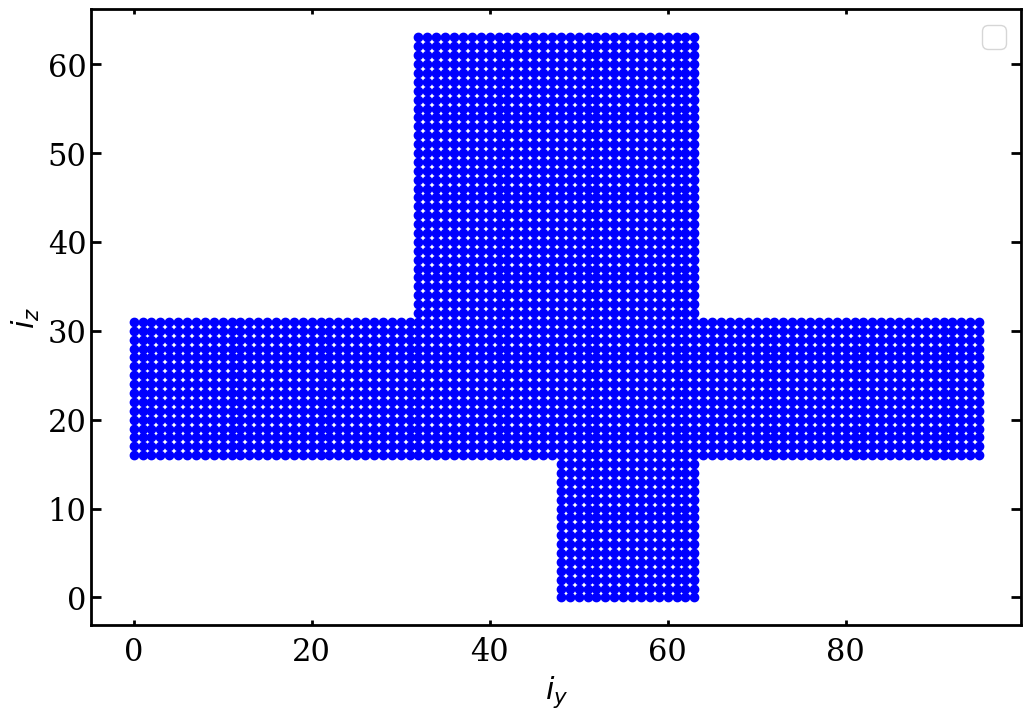

/tmp/ipykernel_1516295/1401053002.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


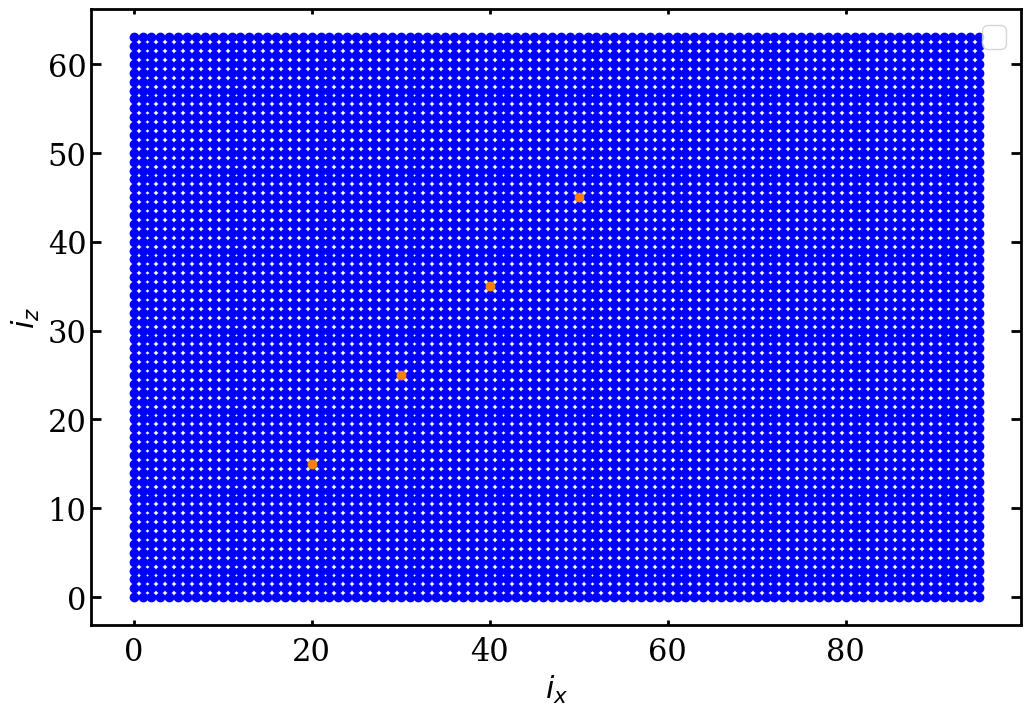

/tmp/ipykernel_1516295/1401053002.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


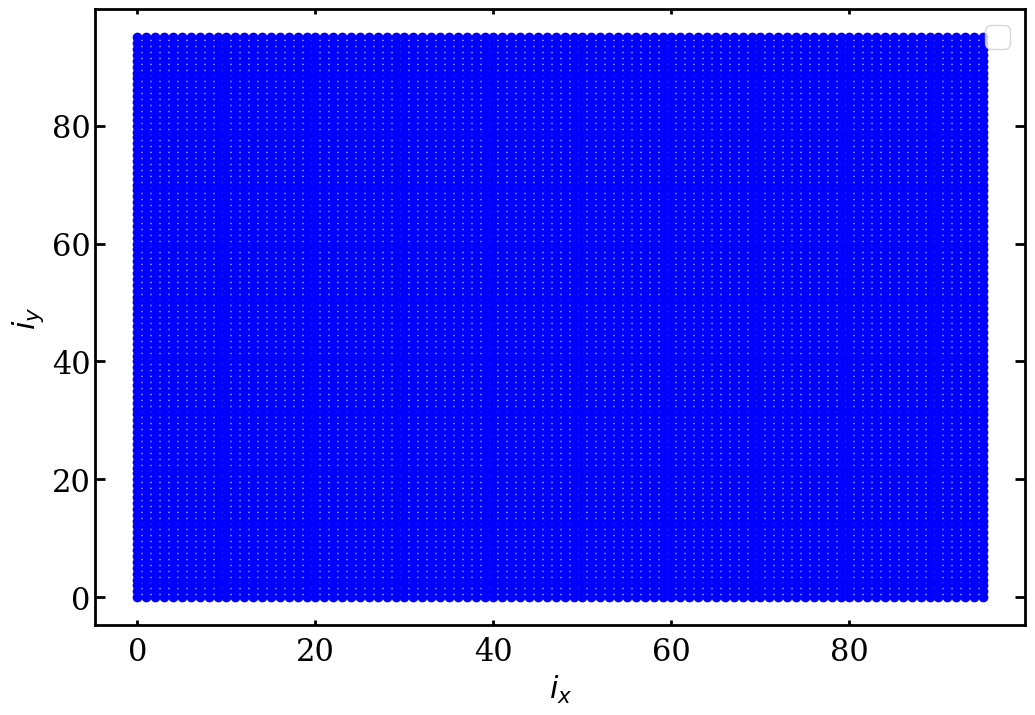

In [47]:
cell_file_names = glob.glob(direct + parfile + '/cell_*_*_*')
cell_file_names = [file_name.split('/')[-1] for file_name in cell_file_names]
x_cell_ind = np.array([int(file_name.split('_')[1]) for file_name in cell_file_names])
y_cell_ind = np.array([int(file_name.split('_')[2]) for file_name in cell_file_names])
z_cell_ind = np.array([int((file_name.split('_')[3]).split('.')[0]) for file_name in cell_file_names])
cell_indices = np.array(list(zip(x_cell_ind, y_cell_ind, z_cell_ind)))

print('Number of cells:', len(cell_indices))
print(f'shape of cell_indices: {cell_indices.shape}')

x_idx_slice = 48
mask_yz_slice = cell_indices[:,0] == x_idx_slice # fixing the x index in this value
cell_indices_yz_slice = cell_indices[mask_yz_slice]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_yz_slice[:,1], cell_indices_yz_slice[:,2], color='b')
ax.set_xlabel('$i_y$')
ax.set_ylabel('$i_z$')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

y_idx_slice = 48
mask_xz_slice = cell_indices[:,1] == y_idx_slice # fixing the y index in this value
cell_indices_xz_slice = cell_indices[mask_xz_slice]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_xz_slice[:,0], cell_indices_xz_slice[:,2], color='b')
ax.scatter([20],[15], color='C1')
ax.scatter([30],[25], color='C1')
ax.scatter([40],[35], color='C1')
ax.scatter([50],[45], color='C1')
ax.set_xlabel('$i_x$')
ax.set_ylabel('$i_z$')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

z_idx_slice = 16
mask_xy_slice = cell_indices[:,2] == z_idx_slice # fixing the z index in this value
cell_indices_xy_slice = cell_indices[mask_xy_slice]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_xy_slice[:,0], cell_indices_xy_slice[:,1], color='b')
ax.set_xlabel('$i_x$')
ax.set_ylabel('$i_y$')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

cell_indices_all = np.concatenate((cell_indices_yz_slice, cell_indices_xz_slice, cell_indices_xy_slice), axis=0)
cell_indices_all = np.unique(cell_indices_all, axis=0)

In [48]:
num_particles_per_ener = 92
num_energy_bins = 13
time_s = 0.0

energybinsMeV = np.array([
    1, 3, 5.2382, 8.0097, 11.442, 15.691, 20.953, 27.468,
    35.536, 45.525, 57.895, 73.212, 92.178, 115.66,
    144.74, 180.75, 225.33, 280.54
])

energybinstopMeV = np.array([
    2, 4, 6.4765, 9.543, 13.34, 18.042, 23.864, 31.073,
    39.999, 51.052, 64.738, 81.685, 102.67, 128.65,
    160.83, 200.67, 250, 311.08
])

energybinsbottomMeV = np.array([
    0, 2, 4, 6.4765, 9.543, 13.34, 18.042, 23.864, 31.073,
    39.999, 51.052, 64.738, 81.685, 102.67, 128.65,
    160.83, 200.67, 250
])

n_ee_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
n_uu_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
n_tt_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
n_eu_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
n_et_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
n_ut_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3

nbar_ee_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
nbar_uu_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
nbar_tt_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
nbar_eu_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
nbar_et_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3
nbar_ut_per_energy_bin = np.zeros((num_energy_bins,) + Xc.shape)  # particles / cm^3

for indexpair in cell_indices_all:
# for indexpair in cell_indices_xz_slice[45:46]:
# for indexpair in cell_indices_xz_slice:
    
    i = indexpair[0]
    j = indexpair[1]
    k = indexpair[2]
    
    parcellname = '/cell_' + str(i) + '_' + str(j) + '_' + str(k) + '.h5'

    particles_h5py = h5py.File(direct+parfile+parcellname, 'r')

    N00_Re    = np.array(particles_h5py['/N00_Re'   ]) # particles
    N11_Re    = np.array(particles_h5py['/N11_Re'   ]) # particles
    N22_Re    = np.array(particles_h5py['/N22_Re'   ]) # particles

    N01_Re    = np.array(particles_h5py['/N01_Re'   ]) # particles
    N02_Re    = np.array(particles_h5py['/N02_Re'   ]) # particles
    N12_Re    = np.array(particles_h5py['/N12_Re'   ]) # particles

    N01_Im    = np.array(particles_h5py['/N01_Im'   ]) # particles
    N02_Im    = np.array(particles_h5py['/N02_Im'   ]) # particles
    N12_Im    = np.array(particles_h5py['/N12_Im'   ]) # particles

    N00_Rebar = np.array(particles_h5py['/N00_Rebar']) # particles
    N11_Rebar = np.array(particles_h5py['/N11_Rebar']) # particles
    N22_Rebar = np.array(particles_h5py['/N22_Rebar']) # particles

    N01_Rebar = np.array(particles_h5py['/N01_Rebar']) # particles
    N02_Rebar = np.array(particles_h5py['/N02_Rebar']) # particles
    N12_Rebar = np.array(particles_h5py['/N12_Rebar']) # particles

    N01_Imbar = np.array(particles_h5py['/N01_Imbar']) # particles
    N02_Imbar = np.array(particles_h5py['/N02_Imbar']) # particles
    N12_Imbar = np.array(particles_h5py['/N12_Imbar']) # particles

    time_s    = np.array(particles_h5py['/time'     ])[0] # seconds

    pupt      = np.array(particles_h5py['/pupt'     ]) # ergs
    pupx     = np.array(particles_h5py['/pupx'     ]) / pupt # unitless
    pupy     = np.array(particles_h5py['/pupy'     ]) / pupt # unitless
    pupz     = np.array(particles_h5py['/pupz'     ]) / pupt # unitless

    energyMeV = pupt / ( 1e6 * pc.CGSUnitsConst.eV ) # MeV
    particles_h5py.close()

    n00_total    = np.sum( N00_Re    ) / cellvolume # particles / cm^3
    n00_totalbar = np.sum( N00_Rebar ) / cellvolume # particles / cm^3
    n11_total    = np.sum( N11_Re    ) / cellvolume # particles / cm^3
    n11_totalbar = np.sum( N11_Rebar ) / cellvolume # particles / cm^3

    for t in range(num_energy_bins):
        energymask = (energyMeV >= energybinsbottomMeV[t]) & (energyMeV < energybinstopMeV[t])
        if np.sum(energymask) != num_particles_per_energy_bin:
            print(f"Warning: Energy bin {t} has {np.sum(energymask)} particles, expected {num_particles_per_energy_bin}")
        
        n_ee_per_energy_bin[t,i,j,k] = np.sum(N00_Re[energymask])    / cellvolume # particles / cm^3
        n_uu_per_energy_bin[t,i,j,k] = np.sum(N11_Re[energymask])    / cellvolume # particles / cm^3
        n_tt_per_energy_bin[t,i,j,k] = np.sum(N22_Re[energymask])    / cellvolume # particles / cm^3
        n_eu_per_energy_bin[t,i,j,k] = (np.sum(N01_Re[energymask]) + 1.0j * np.sum(N01_Im[energymask])) / cellvolume # particles / cm^3
        n_et_per_energy_bin[t,i,j,k] = (np.sum(N02_Re[energymask]) + 1.0j * np.sum(N02_Im[energymask])) / cellvolume # particles / cm^3
        n_ut_per_energy_bin[t,i,j,k] = (np.sum(N12_Re[energymask]) + 1.0j * np.sum(N12_Im[energymask])) / cellvolume # particles / cm^3

        nbar_ee_per_energy_bin[t,i,j,k] = np.sum(N00_Rebar[energymask])    / cellvolume # particles / cm^3
        nbar_uu_per_energy_bin[t,i,j,k] = np.sum(N11_Rebar[energymask])    / cellvolume # particles / cm^3
        nbar_tt_per_energy_bin[t,i,j,k] = np.sum(N22_Rebar[energymask])    / cellvolume # particles / cm^3
        nbar_eu_per_energy_bin[t,i,j,k] = (np.sum(N01_Rebar[energymask]) + 1.0j * np.sum(N01_Imbar[energymask])) / cellvolume # particles / cm^3
        nbar_et_per_energy_bin[t,i,j,k] = (np.sum(N02_Rebar[energymask]) + 1.0j * np.sum(N02_Imbar[energymask])) / cellvolume # particles / cm^3
        nbar_ut_per_energy_bin[t,i,j,k] = (np.sum(N12_Rebar[energymask]) + 1.0j * np.sum(N12_Imbar[energymask])) / cellvolume # particles / cm^3

/tmp/ipykernel_1516295/1545775235.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  n_eu_per_energy_bin[t,i,j,k] = (np.sum(N01_Re[energymask]) + 1.0j * np.sum(N01_Im[energymask])) / cellvolume # particles / cm^3
/tmp/ipykernel_1516295/1545775235.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  n_et_per_energy_bin[t,i,j,k] = (np.sum(N02_Re[energymask]) + 1.0j * np.sum(N02_Im[energymask])) / cellvolume # particles / cm^3
/tmp/ipykernel_1516295/1545775235.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  n_ut_per_energy_bin[t,i,j,k] = (np.sum(N12_Re[energymask]) + 1.0j * np.sum(N12_Im[energymask])) / cellvolume # particles / cm^3
/tmp/ipykernel_1516295/1545775235.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  nbar_eu_per_energy_bin[t,i,j,k] = (np.sum(N01_Rebar[energymask]) + 1.0j * np.sum(N01_Imbar[energymask])) / cellvolume # particles / cm^3
/tmp/i

/tmp/ipykernel_1516295/2098614780.py:38: RuntimeWarning: divide by zero encountered in log10
  z=np.log10(np.abs(n_eu_per_energy_bin[e,:,y_idx_slice,:])),


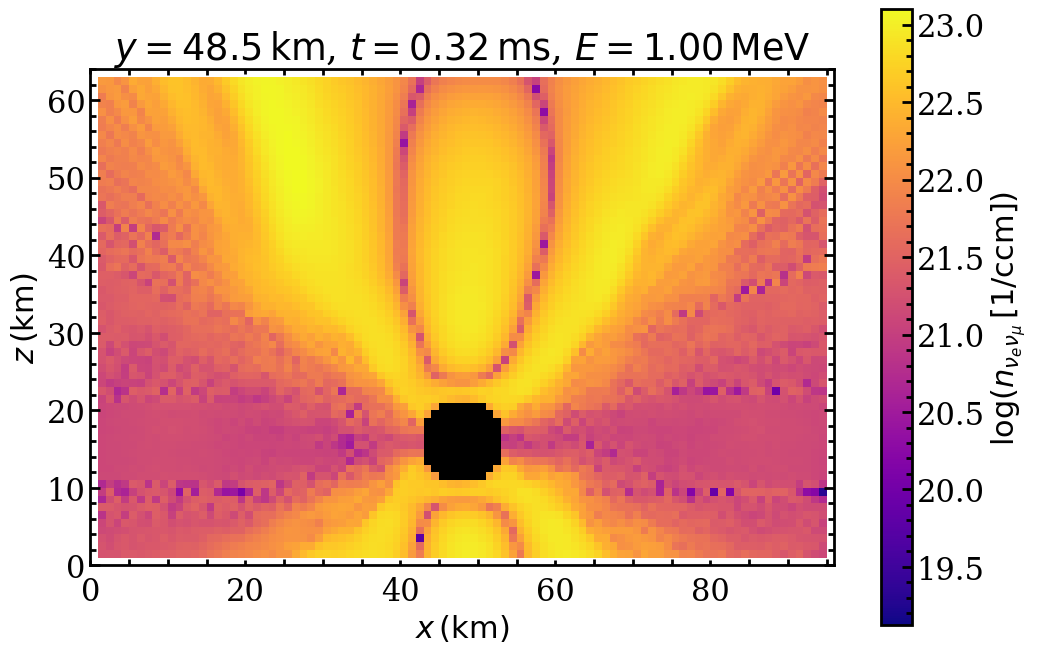

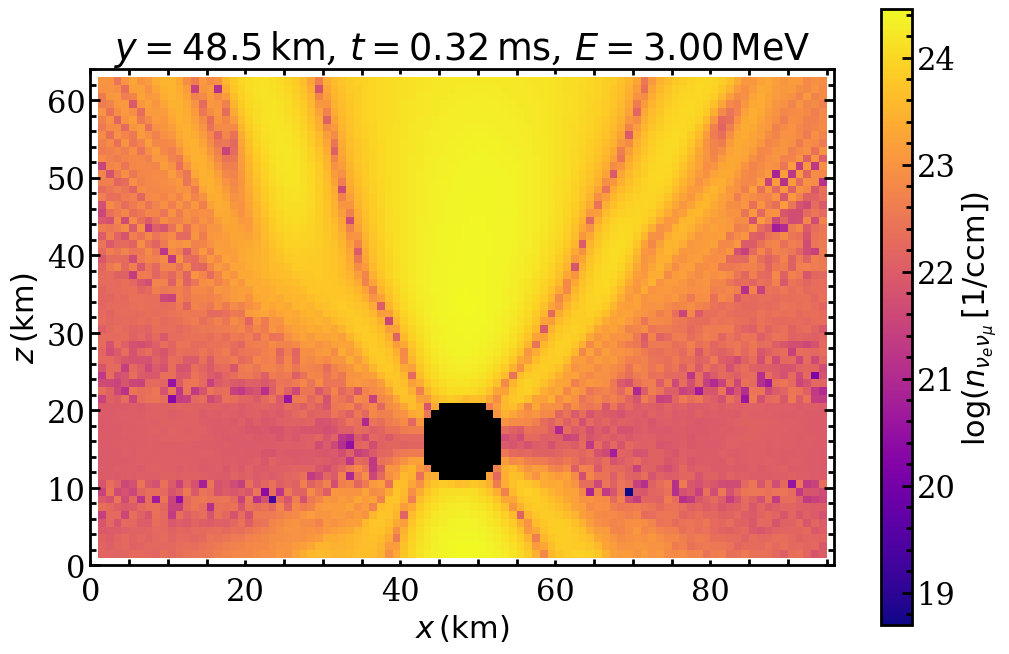

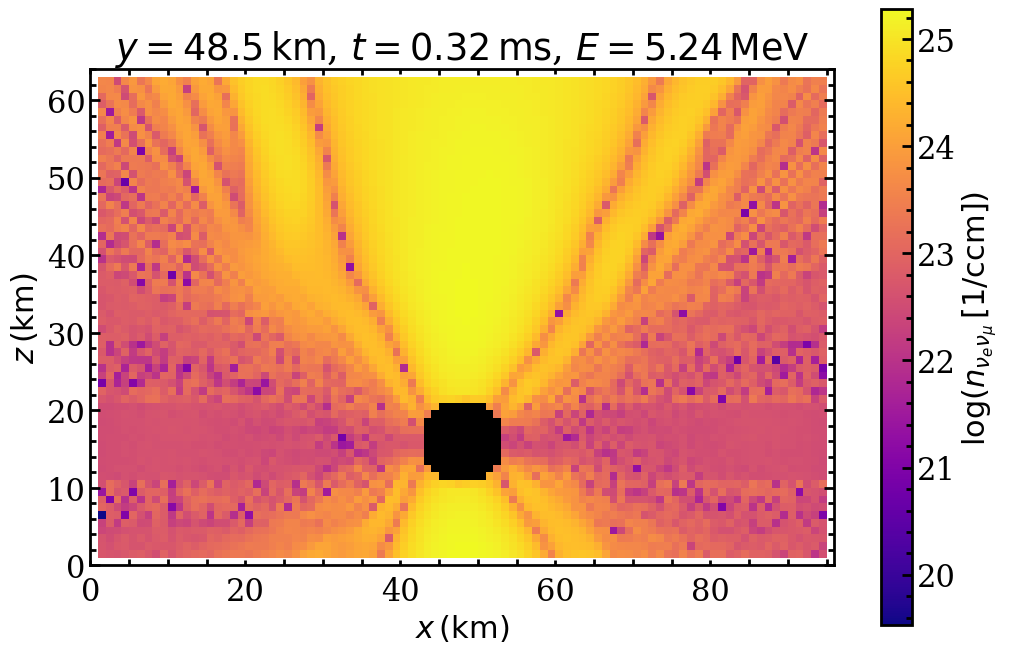

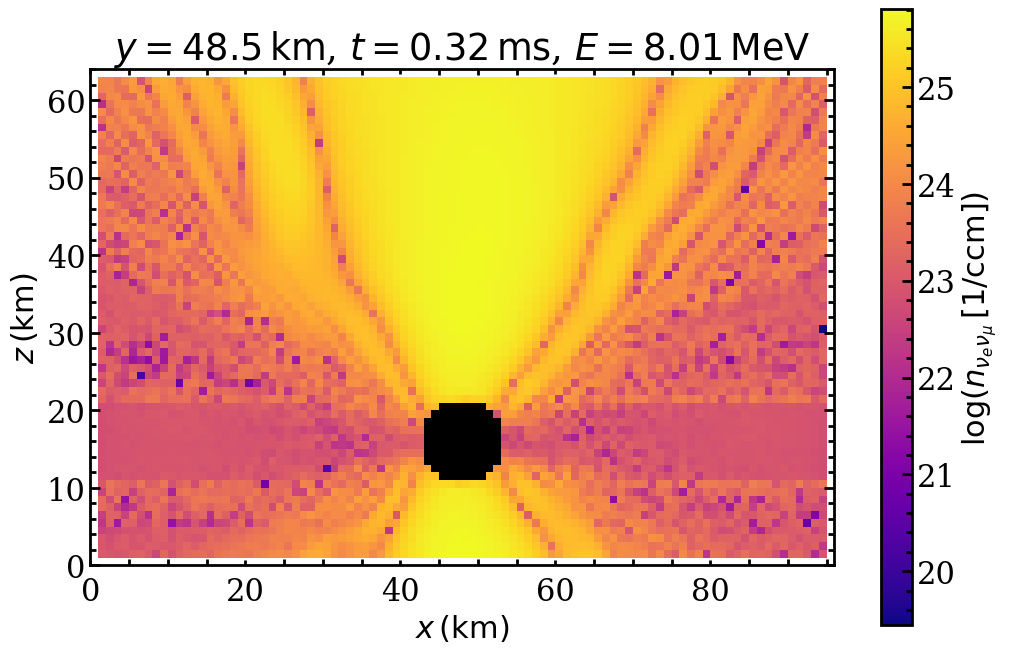

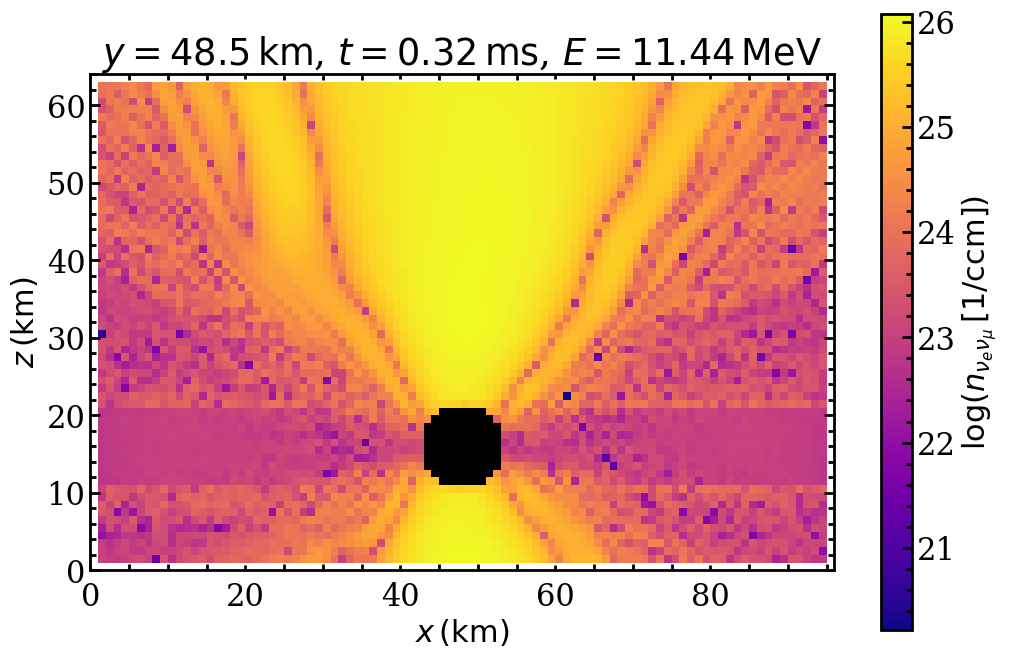

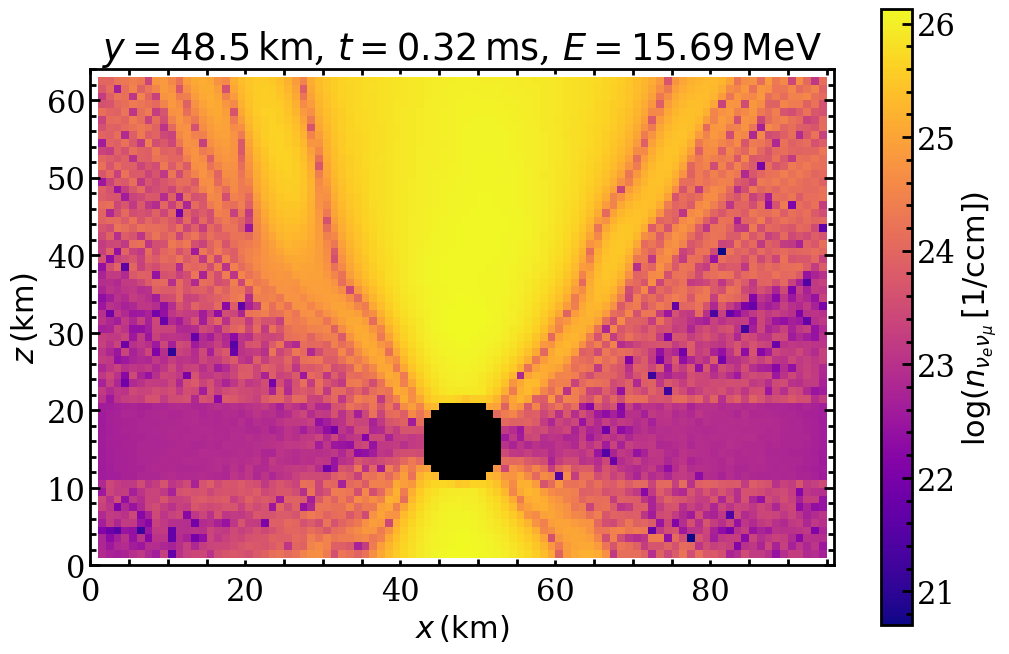

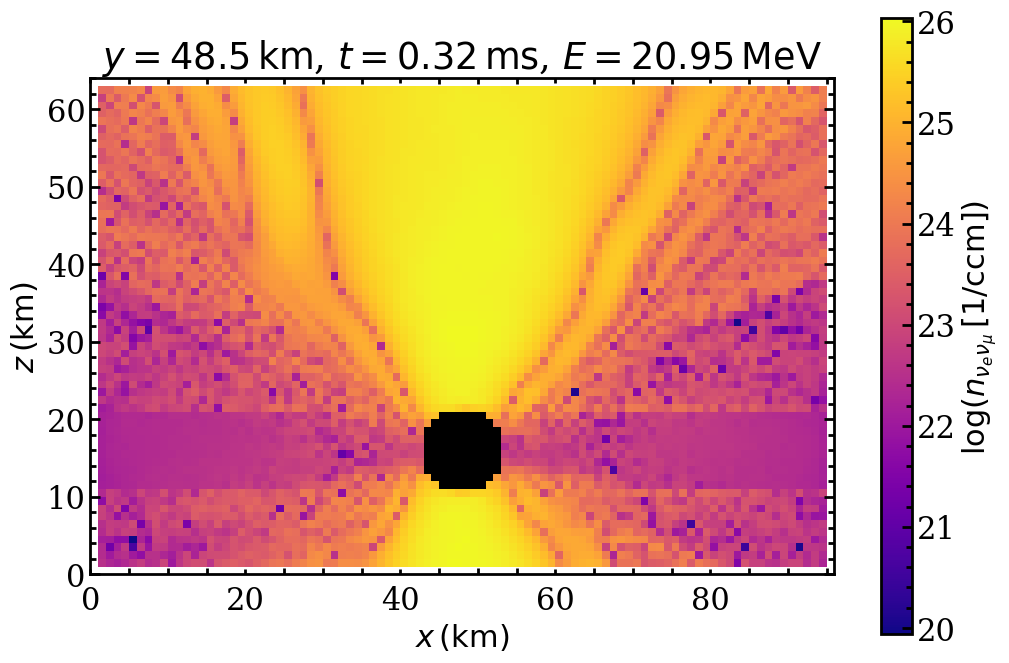

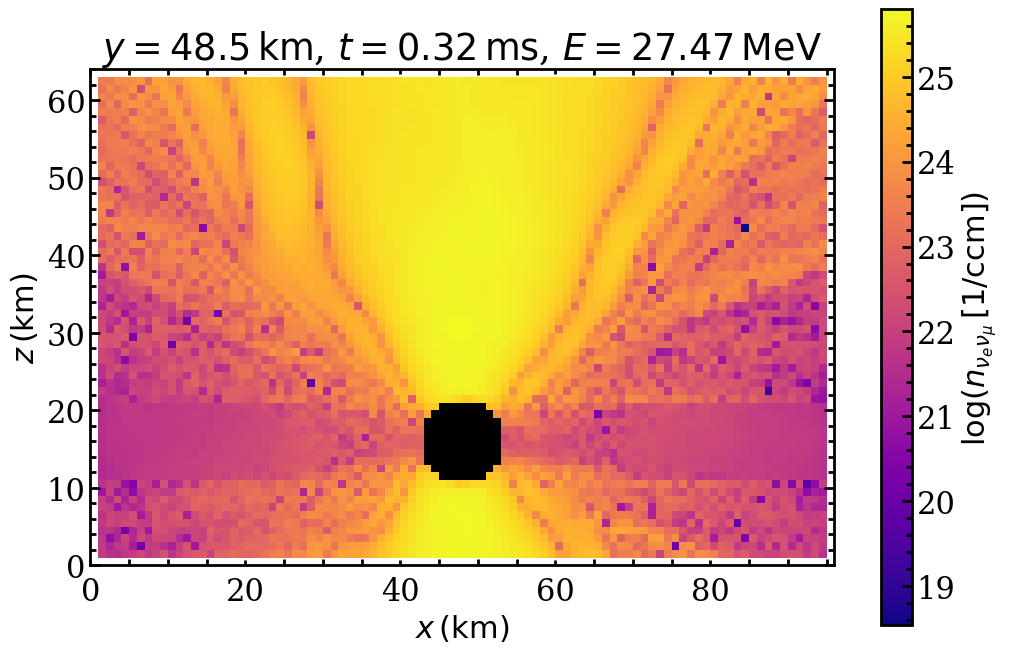

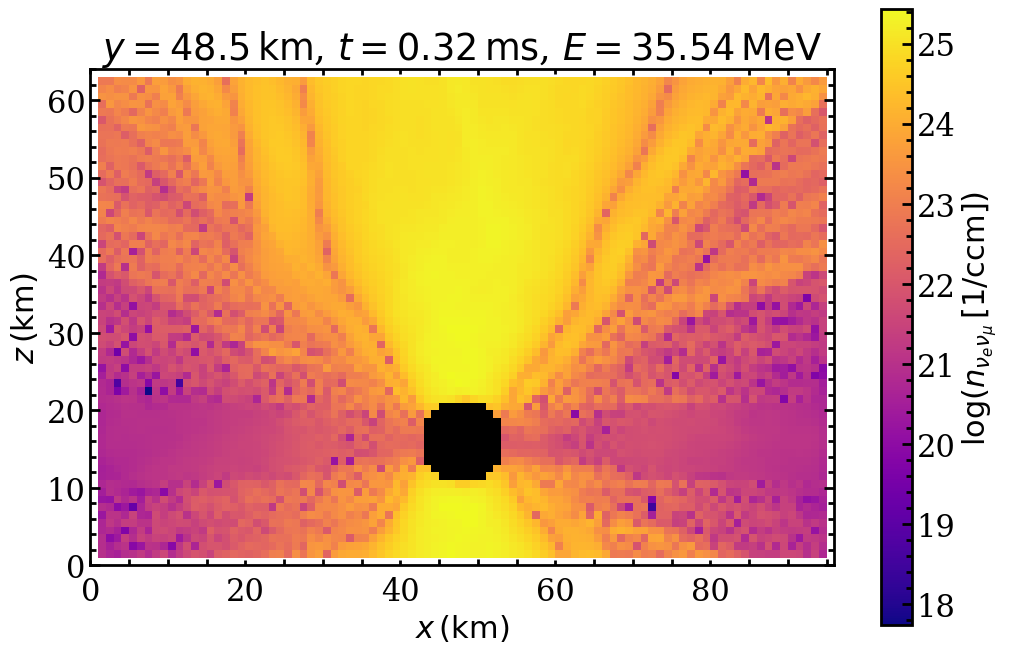

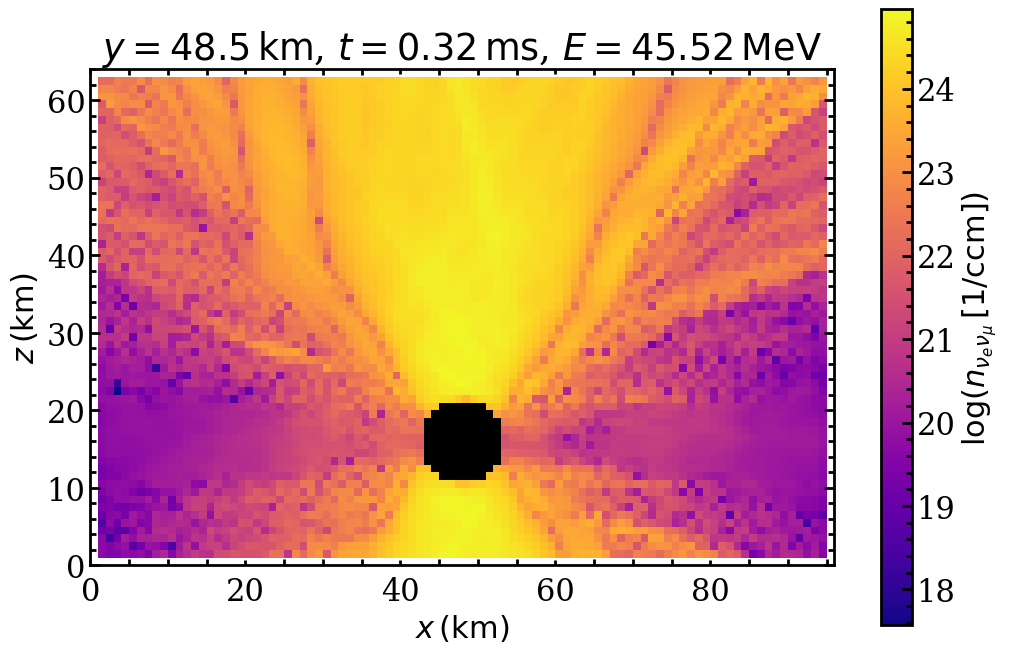

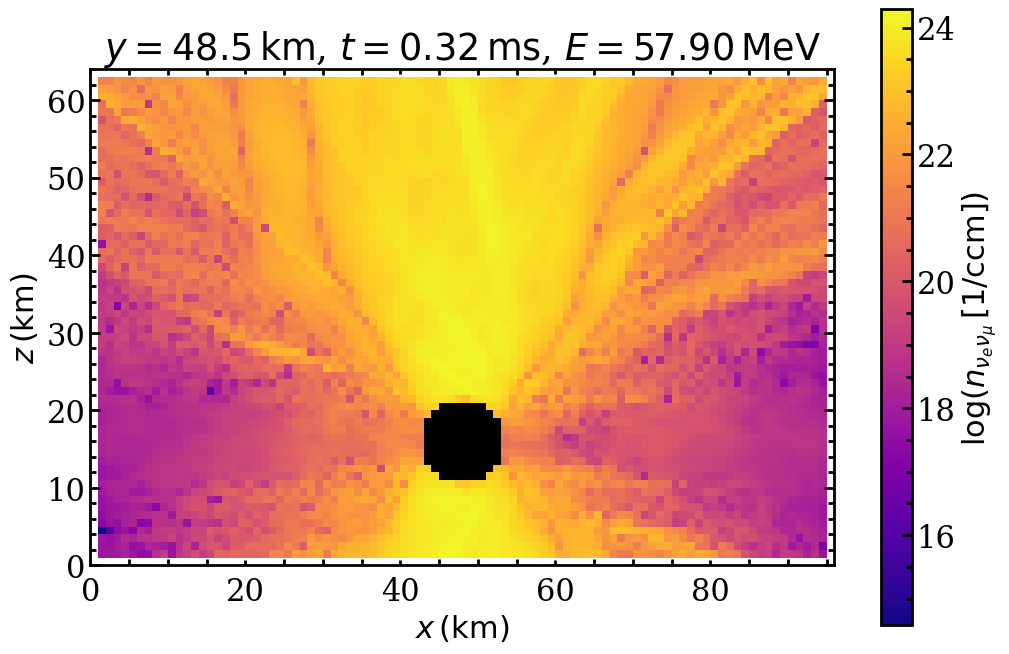

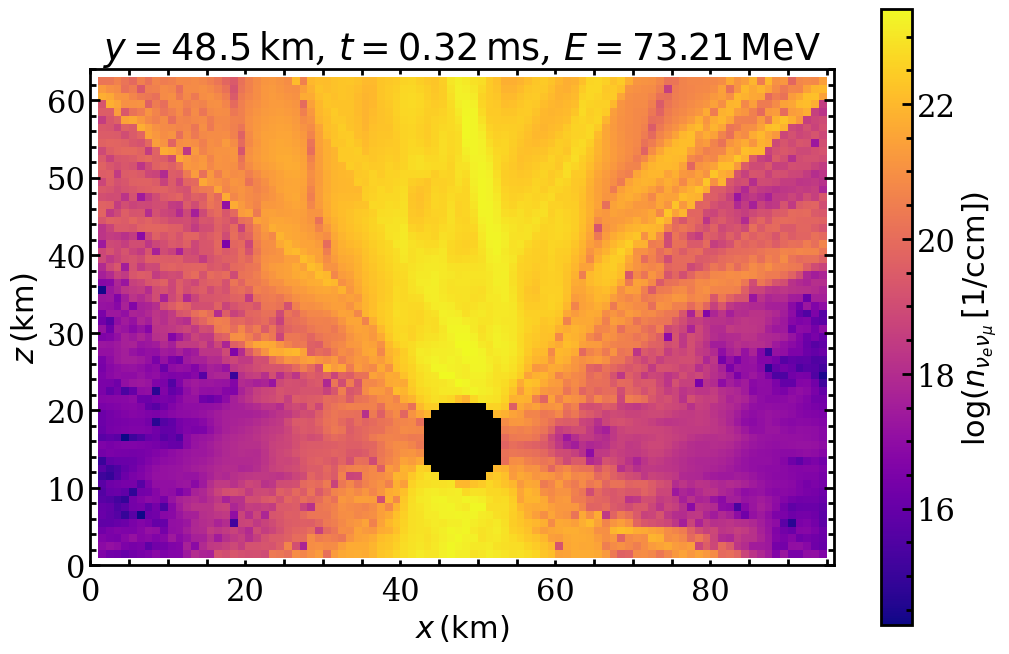

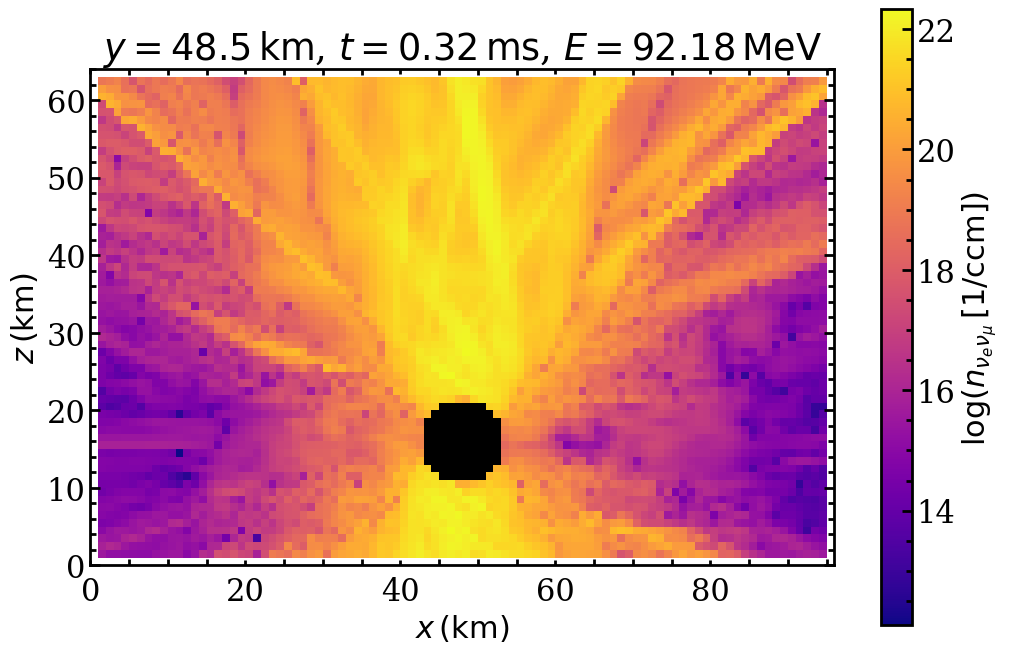

In [49]:
for e in range(num_energy_bins):

    # # electron neutrino
    # pf.plot_color_map_with_scattered_points(
    #     x=Xc[:,y_idx_slice,:]/1.0e5,  # Convert to km
    #     y=Zc[:,y_idx_slice,:]/1.0e5,  # Convert to km
    #     z=np.log10(n_ee_per_energy_bin[e,:,y_idx_slice,:]),
    #     bh_r=5.43, # km
    #     bh_x=48.0, # km
    #     bh_y=16.0, # km
    #     min_cb=None,
    #     max_cb=None,
    #     # min_cb=2.75,
    #     # max_cb=4.75,
    #     x_label=r'$x \, (\mathrm{km})$',
    #     y_label=r'$z \, (\mathrm{km})$',
    #     title=fr'$y={Yc[0,y_idx_slice,0]/1.0e5}\,\mathrm{{km}}$, $t = {time_s/1e-3:.2f}\,\mathrm{{ms}}$',
    #     cbar_label=r'$\log(n_{\nu_e\nu_e}\,[1/\mathrm{ccm}])$',
    #     colormap='plasma',
    #     filename='./plots/'+finaldir+f'_{time_s/1e-3:.2f}ms_sigmaCFI_xz.png',
    #     # x_scat=[48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5],
    #     # y_scat=[25.5, 30.5, 35.5, 40.5, 45.5, 50.5, 55.5, 60.5],
    #     # x_scat=[32],
    #     # y_scat=[15],
    #     x_scat=None,
    #     y_scat=None,
    #     size_scat=50,
    #     marker_scat='x',
    #     color_scat='black',
    #     doshow=True,
    #     dosave=True 
    # )

    # electron-muon neutrino
    pf.plot_color_map_with_scattered_points(
        x=Xc[:,y_idx_slice,:]/1.0e5,  # Convert to km
        y=Zc[:,y_idx_slice,:]/1.0e5,  # Convert to km
        z=np.log10(np.abs(n_eu_per_energy_bin[e,:,y_idx_slice,:])),
        bh_r=5.43, # km
        bh_x=48.0, # km
        bh_y=16.0, # km
        min_cb=None,
        max_cb=None,
        # min_cb=2.75,
        # max_cb=4.75,
        x_label=r'$x \, (\mathrm{km})$',
        y_label=r'$z \, (\mathrm{km})$',
        title=fr'$y={Yc[0,y_idx_slice,0]/1.0e5}\,\mathrm{{km}}$, $t = {time_s/1e-3:.2f}\,\mathrm{{ms}}$, $E = {energybinsMeV[e]:.2f} \,\mathrm{{MeV}}$',
        cbar_label=r'$\log(n_{\nu_e\nu_\mu}\,[1/\mathrm{ccm}])$',
        colormap='plasma',
        filename='./plots/'+finaldir+f'_{time_s/1e-3:.2f}ms_sigmaCFI_xz.png',
        # x_scat=[48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5],
        # y_scat=[25.5, 30.5, 35.5, 40.5, 45.5, 50.5, 55.5, 60.5],
        # x_scat=[32],
        # y_scat=[15],
        x_scat=None,
        y_scat=None,
        size_scat=50,
        marker_scat='x',
        color_scat='black',
        doshow=True,
        dosave=True 
    )

/tmp/ipykernel_1516295/2414624028.py:7: RuntimeWarning: divide by zero encountered in log10
  z=np.log10(np.abs(n_eu_per_energy_bin[e,:,:,z_idx_slice])),


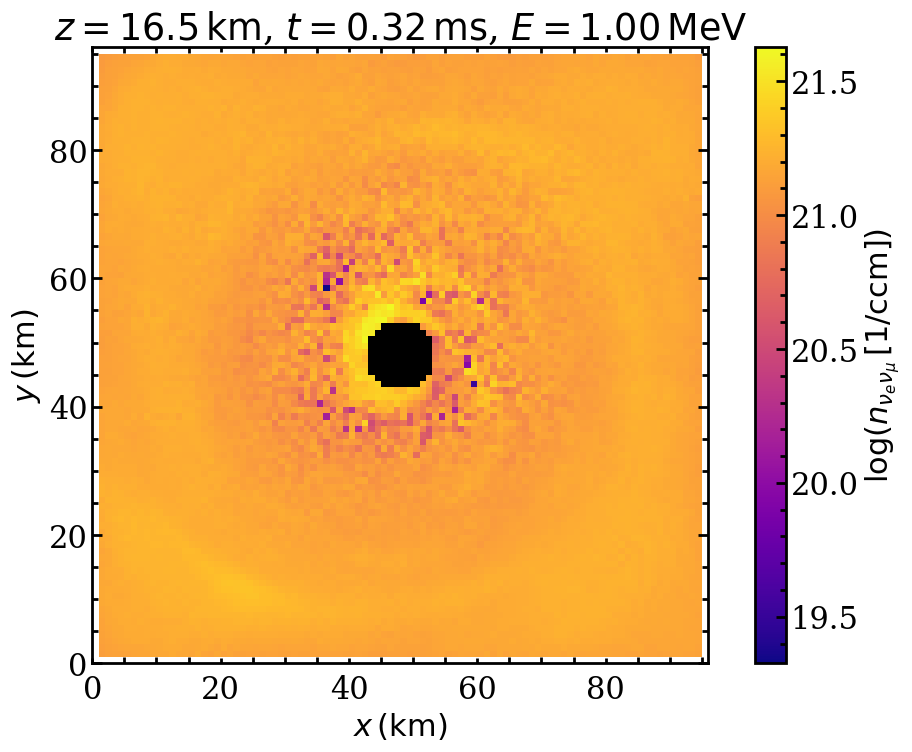

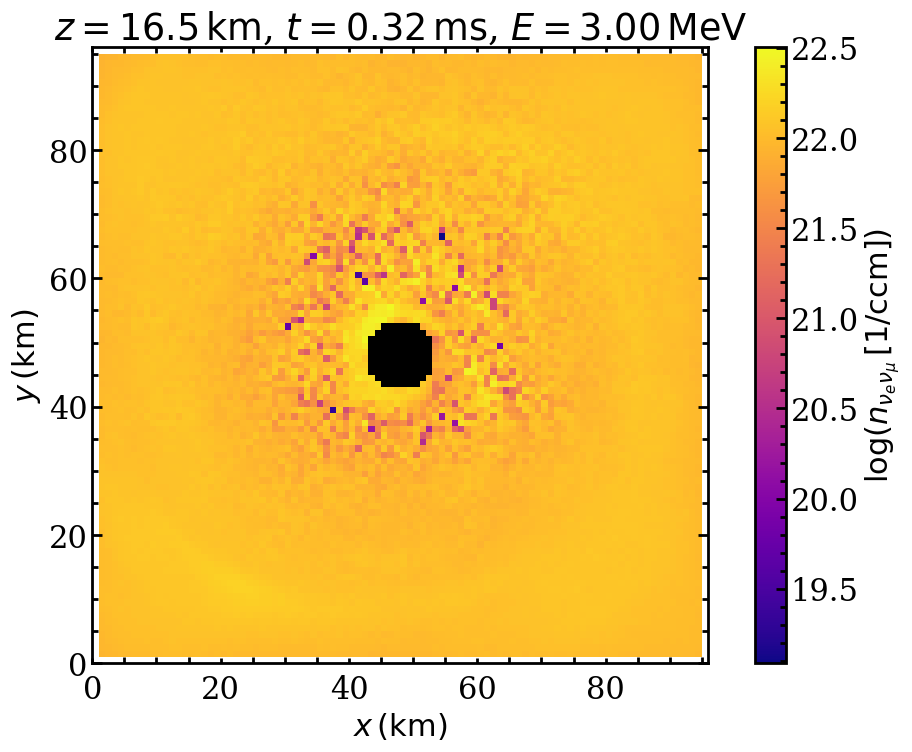

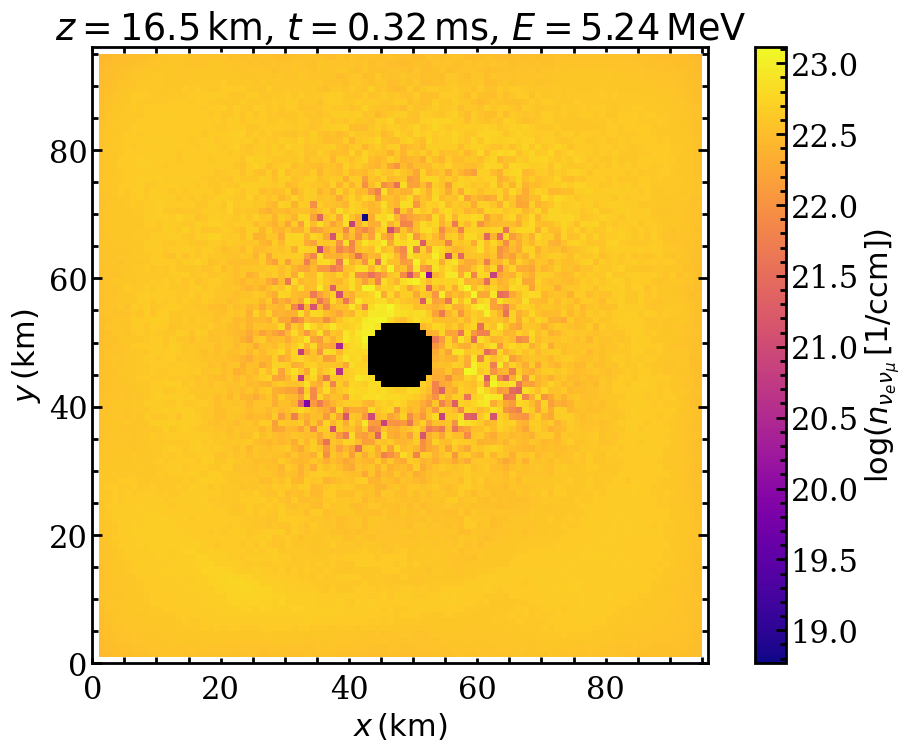

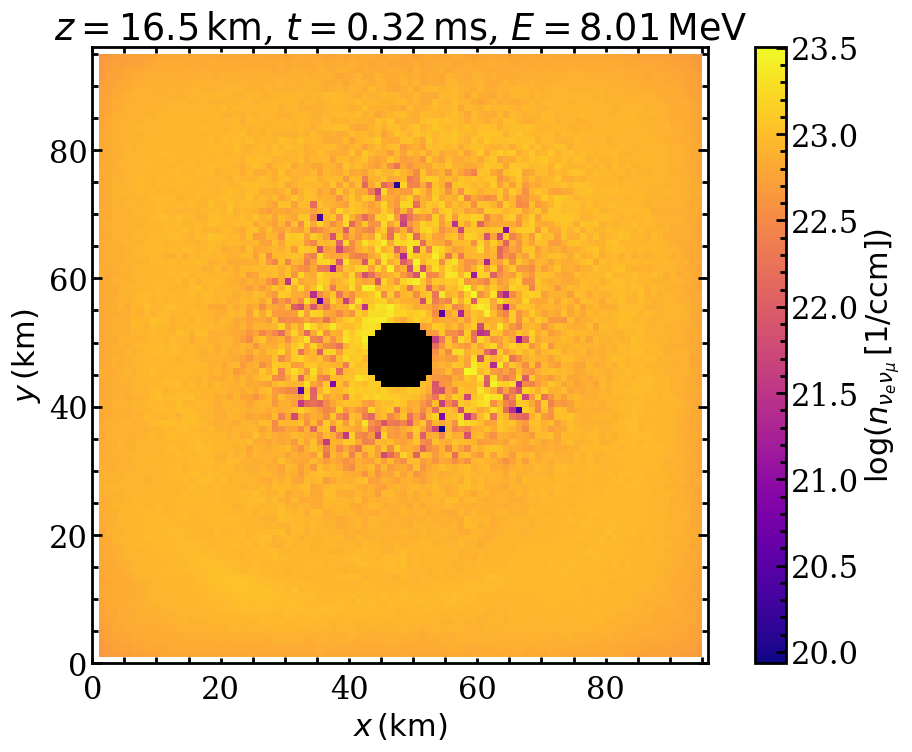

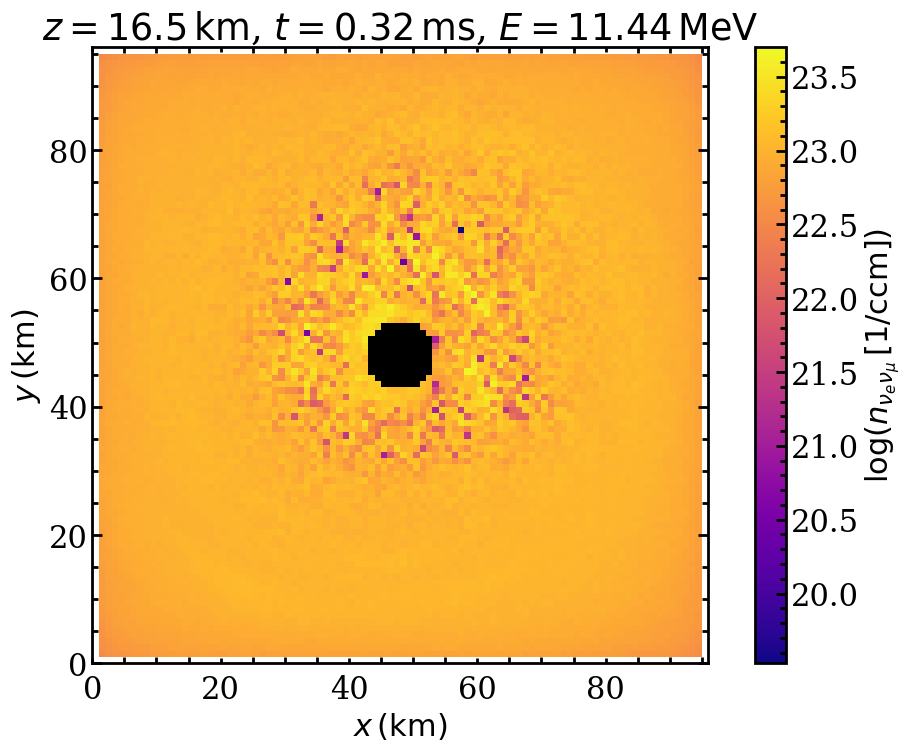

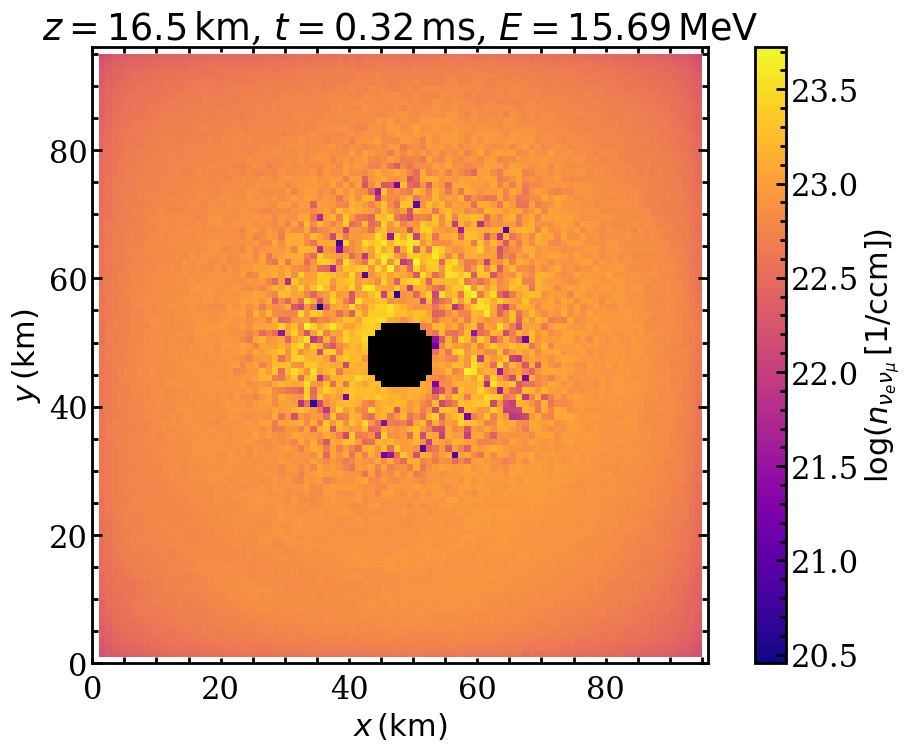

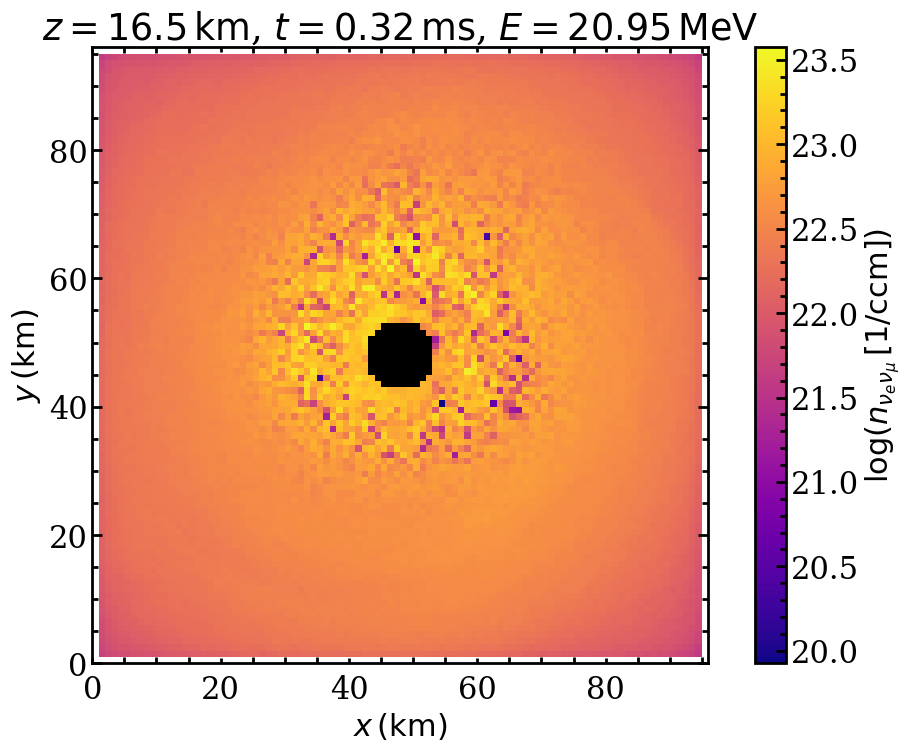

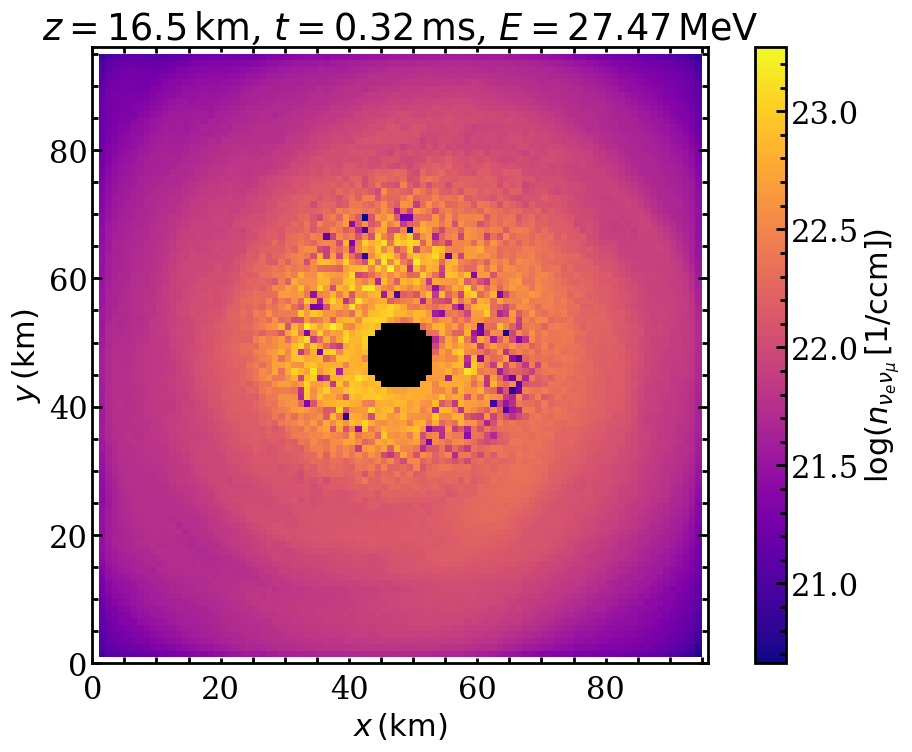

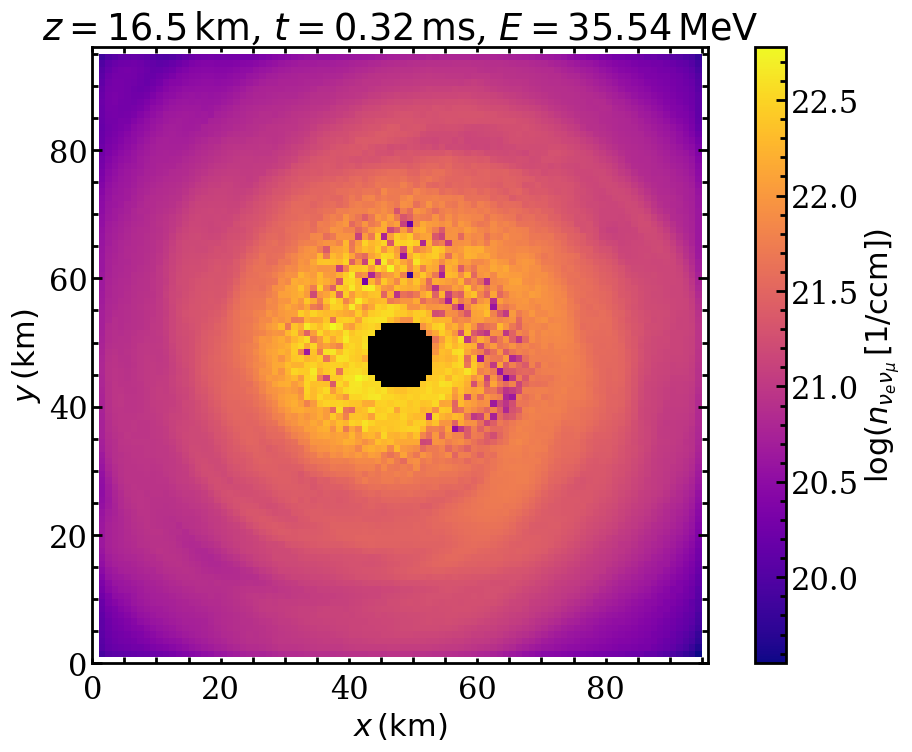

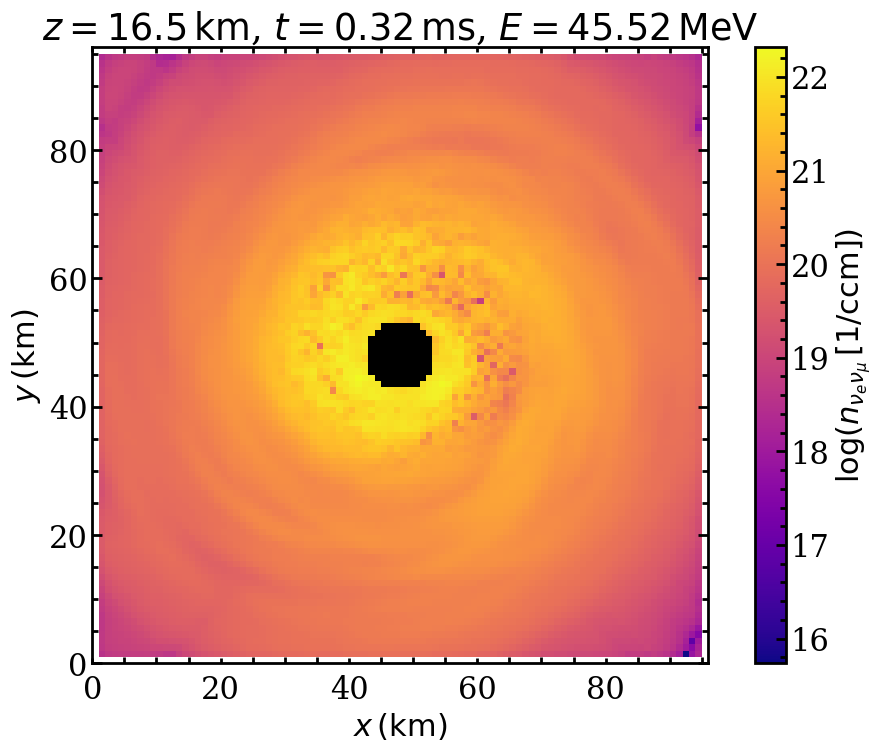

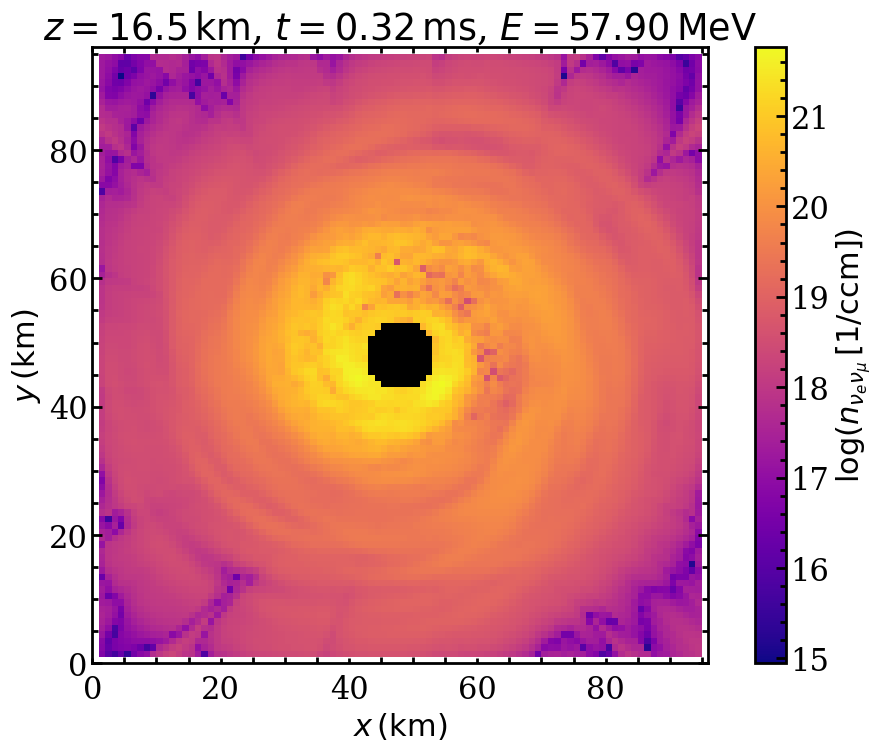

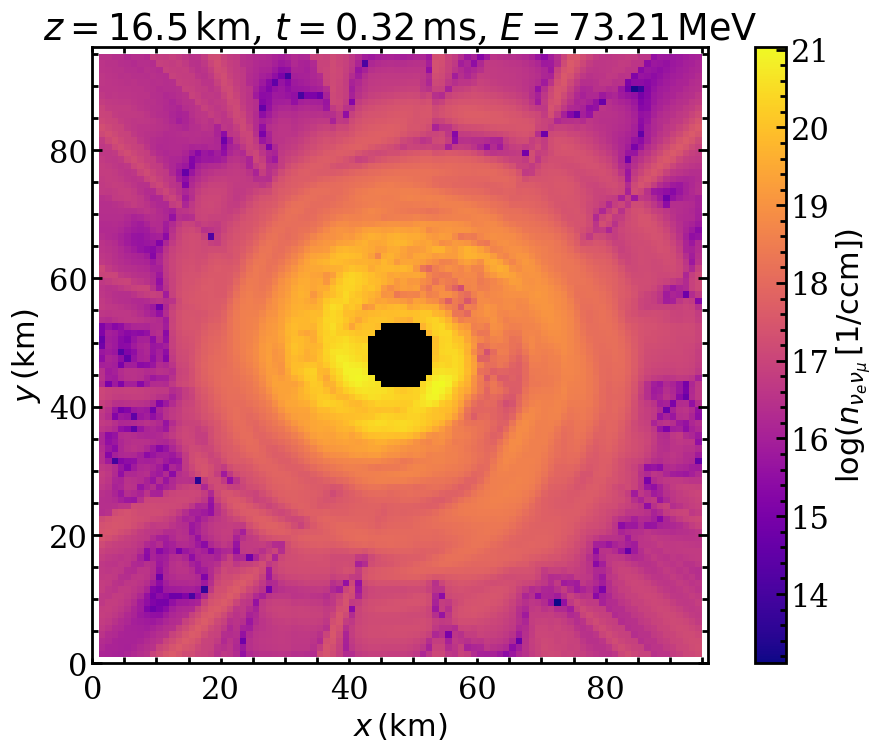

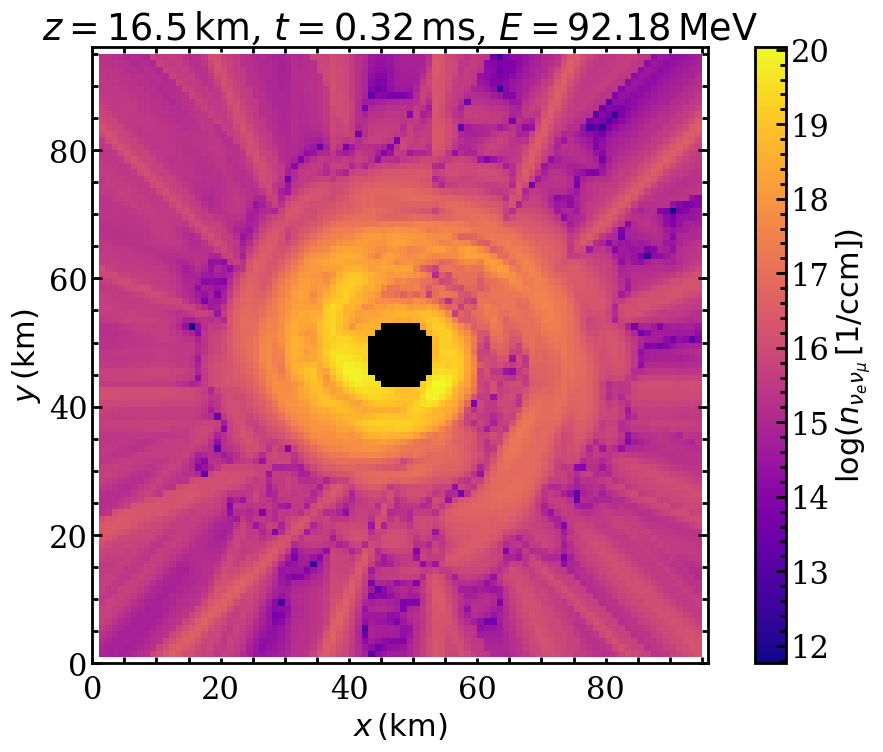

In [50]:
for e in range(num_energy_bins):

    # electron-muon neutrino
    pf.plot_color_map_with_scattered_points(
        x=Xc[:,:,z_idx_slice]/1.0e5,  # Convert to km
        y=Yc[:,:,z_idx_slice]/1.0e5,  # Convert to km
        z=np.log10(np.abs(n_eu_per_energy_bin[e,:,:,z_idx_slice])),
       bh_r=5.43, # km
        bh_x=48.0, # km
        bh_y=48.0, # km
        min_cb=None,
        max_cb=None,
        # min_cb=2.75,
        # max_cb=4.75,
        x_label=r'$x \, (\mathrm{km})$',
        y_label=r'$y \, (\mathrm{km})$',
        title=fr'$z={Zc[0,0,z_idx_slice]/1.0e5}\,\mathrm{{km}}$, $t = {time_s/1e-3:.2f}\,\mathrm{{ms}}$, $E = {energybinsMeV[e]:.2f} \,\mathrm{{MeV}}$',
        cbar_label=r'$\log(n_{\nu_e\nu_\mu}\,[1/\mathrm{ccm}])$',
        colormap='plasma',
        filename='./plots/'+finaldir+f'_{time_s/1e-3:.2f}ms_sigmaCFI_xy.png',
        # x_scat=[48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5],
        # y_scat=[25.5, 30.5, 35.5, 40.5, 45.5, 50.5, 55.5, 60.5],
        # x_scat=[32],
        # y_scat=[15],
        x_scat=None,
        y_scat=None,
        size_scat=50,
        marker_scat='x',
        color_scat='black',
        doshow=True,
        dosave=True 
    )
